In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/AI ML Project/ProjectTrainingData.csv"
df_train = pd.read_csv(path)
df_train.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,1.000009e+18,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,2,15706,320,50,1722,0,35,-1,79
1,1.000017e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
2,1.000037e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15704,320,50,1722,0,35,100084,79
3,1.000064e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,...,1,0,15706,320,50,1722,0,35,100084,79
4,1.000068e+19,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,...,1,0,18993,320,50,2161,0,35,-1,157


In [ ]:
df_test = pd.read_csv("/content/drive/MyDrive/AI ML Project/ProjectTestData.csv")

In [ ]:
df_test.head()

,id,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,...,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
0,3295858251275419735,14102809,1005,1,85f751fd,c4e18dd6,50e219e0,1dc72b4d,2347f47a,0f2161f8,...,1,0,8334,300,50,761,3,175,100075,23
1,12281702837842634283,14103120,1007,0,85f751fd,c4e18dd6,50e219e0,8311368f,1dc9b529,0f2161f8,...,1,2,24303,320,50,2788,3,295,100194,240
2,4638380339534007785,14103109,1005,0,4e7614cf,c1aa3c04,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,24165,320,50,2776,0,35,-1,79
3,17039804736879076347,14103101,1002,0,48c42b43,de0f0f82,50e219e0,ecad2386,7801e8d9,07d7df22,...,0,0,23438,320,50,2684,2,1327,-1,52
4,5753064066292192109,14103119,1005,1,e151e245,7e091613,f028772b,ecad2386,7801e8d9,07d7df22,...,1,0,24084,320,50,2761,2,35,100148,13


### Pre-Processing

- Identifying numerical and categorical features
  - Encode categorical features
  - Scale numerical features
- Manipulate hour column



In [ ]:
## Pre-Processing Function for dealing with both test and train

# Pre-Processing

In [ ]:
def pre_processing(train,test):

    # Encoding categorical values using Label Encoder for matching both training and testing

    le = LabelEncoder()

    for col in train.drop(['id','click','hour'], axis = 1).columns:
        # Encoding categorical values
        if train[col].dtype == 'object':
            le.fit(pd.concat([train[col], test[col]],ignore_index=True))
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])

    # Sampling the training dataset for the initial baseline phase
    train = train.sample(n = 5000000, random_state = 42)



"""

    Sampling for the second phase by considering the class imbalance
    This involves filtering and balancing the training dataset by sampling from classes
    labeled '1' and '0' to achieve a more representative mix for model training.


    target_1= train['click'] == 1
    train_1 = train[target_1]
    target_0 = train['click'] == 0
    train_0 = train[target_0]

    # Sample 45% of one and 55% of zeroes
    train_0_sampled = train_0.sample(n = len(train_1) + 1000, random_state = 42)
    train = pd.concat([train_1,train_0_sampled])

"""


    # dropping target if train = 'True'
    df_X = train.drop(['id','click'], axis = 1)
    df_y = train['click']

    # Split the data into training and validation sets
    X_train, X_val ,y_train, y_val = train_test_split(df_X,df_y , test_size=0.2, stratify=df_y, random_state=42)

    ## Scaling numerical values in the provided dataset

    df_excluded = X_train.drop('hour', axis=1)
    numerical_cols = df_excluded.select_dtypes(include=['int64']).columns

    scaler = StandardScaler()

    for col in numerical_cols:

        # Fit the scaler on the training data
        scaler.fit(X_train[[col]])

        # Transform both training and validation data
        X_train[col] = scaler.transform(X_train[[col]])
        X_val[col] = scaler.transform(X_val[[col]])
        test[col] = scaler.transform(test[[col]])

    return X_train,X_val,y_train, y_val,test

In [ ]:
X_train,X_val,y_train, y_val,test = pre_processing(df_train, df_test)

In [ ]:
# Handling the date column

def change_date_time(data):
    data ['hour'] = pd.to_datetime(data['hour'], format = '%y%m%d%H')
    data['dayofweek'] = data['hour'].dt.dayofweek
    data['day'] = data['hour'].dt.day
    data['hour'] = data['hour'].dt.hour
    return data

In [ ]:
X_train = change_date_time(X_train)
X_val = change_date_time(X_val)
df_test = change_date_time(test)

In [ ]:
X_train.shape,X_val.shape,df_test.shape

((4000000, 24), (1000000, 24), (13015341, 25))

In [ ]:
# Feature importance

def feature_importance(X_train,y_train):
    # Creating a random forest classifier
    model = RandomForestClassifier()
    model.fit(X_train, y_train)

    #Computing feature importances
    importances = model.feature_importances_

    feature_importances = pd.Series(importances, index=X_train.columns)
    #Sorting the feature importances in descending order
    sorted_importances = feature_importances.sort_values(ascending=False)
    #Creating a horizontal bar plot of the feature importances
    plt.figure(figsize=(12, 8))
    sorted_importances.plot(kind='barh', color='skyblue')
    plt.title('Feature Importance using Random Forest')
    plt.ylabel('Features')
    plt.xlabel('Importance')

    plt.gca().invert_yaxis()
    plt.show()


#  Checking Outliers in the dataset

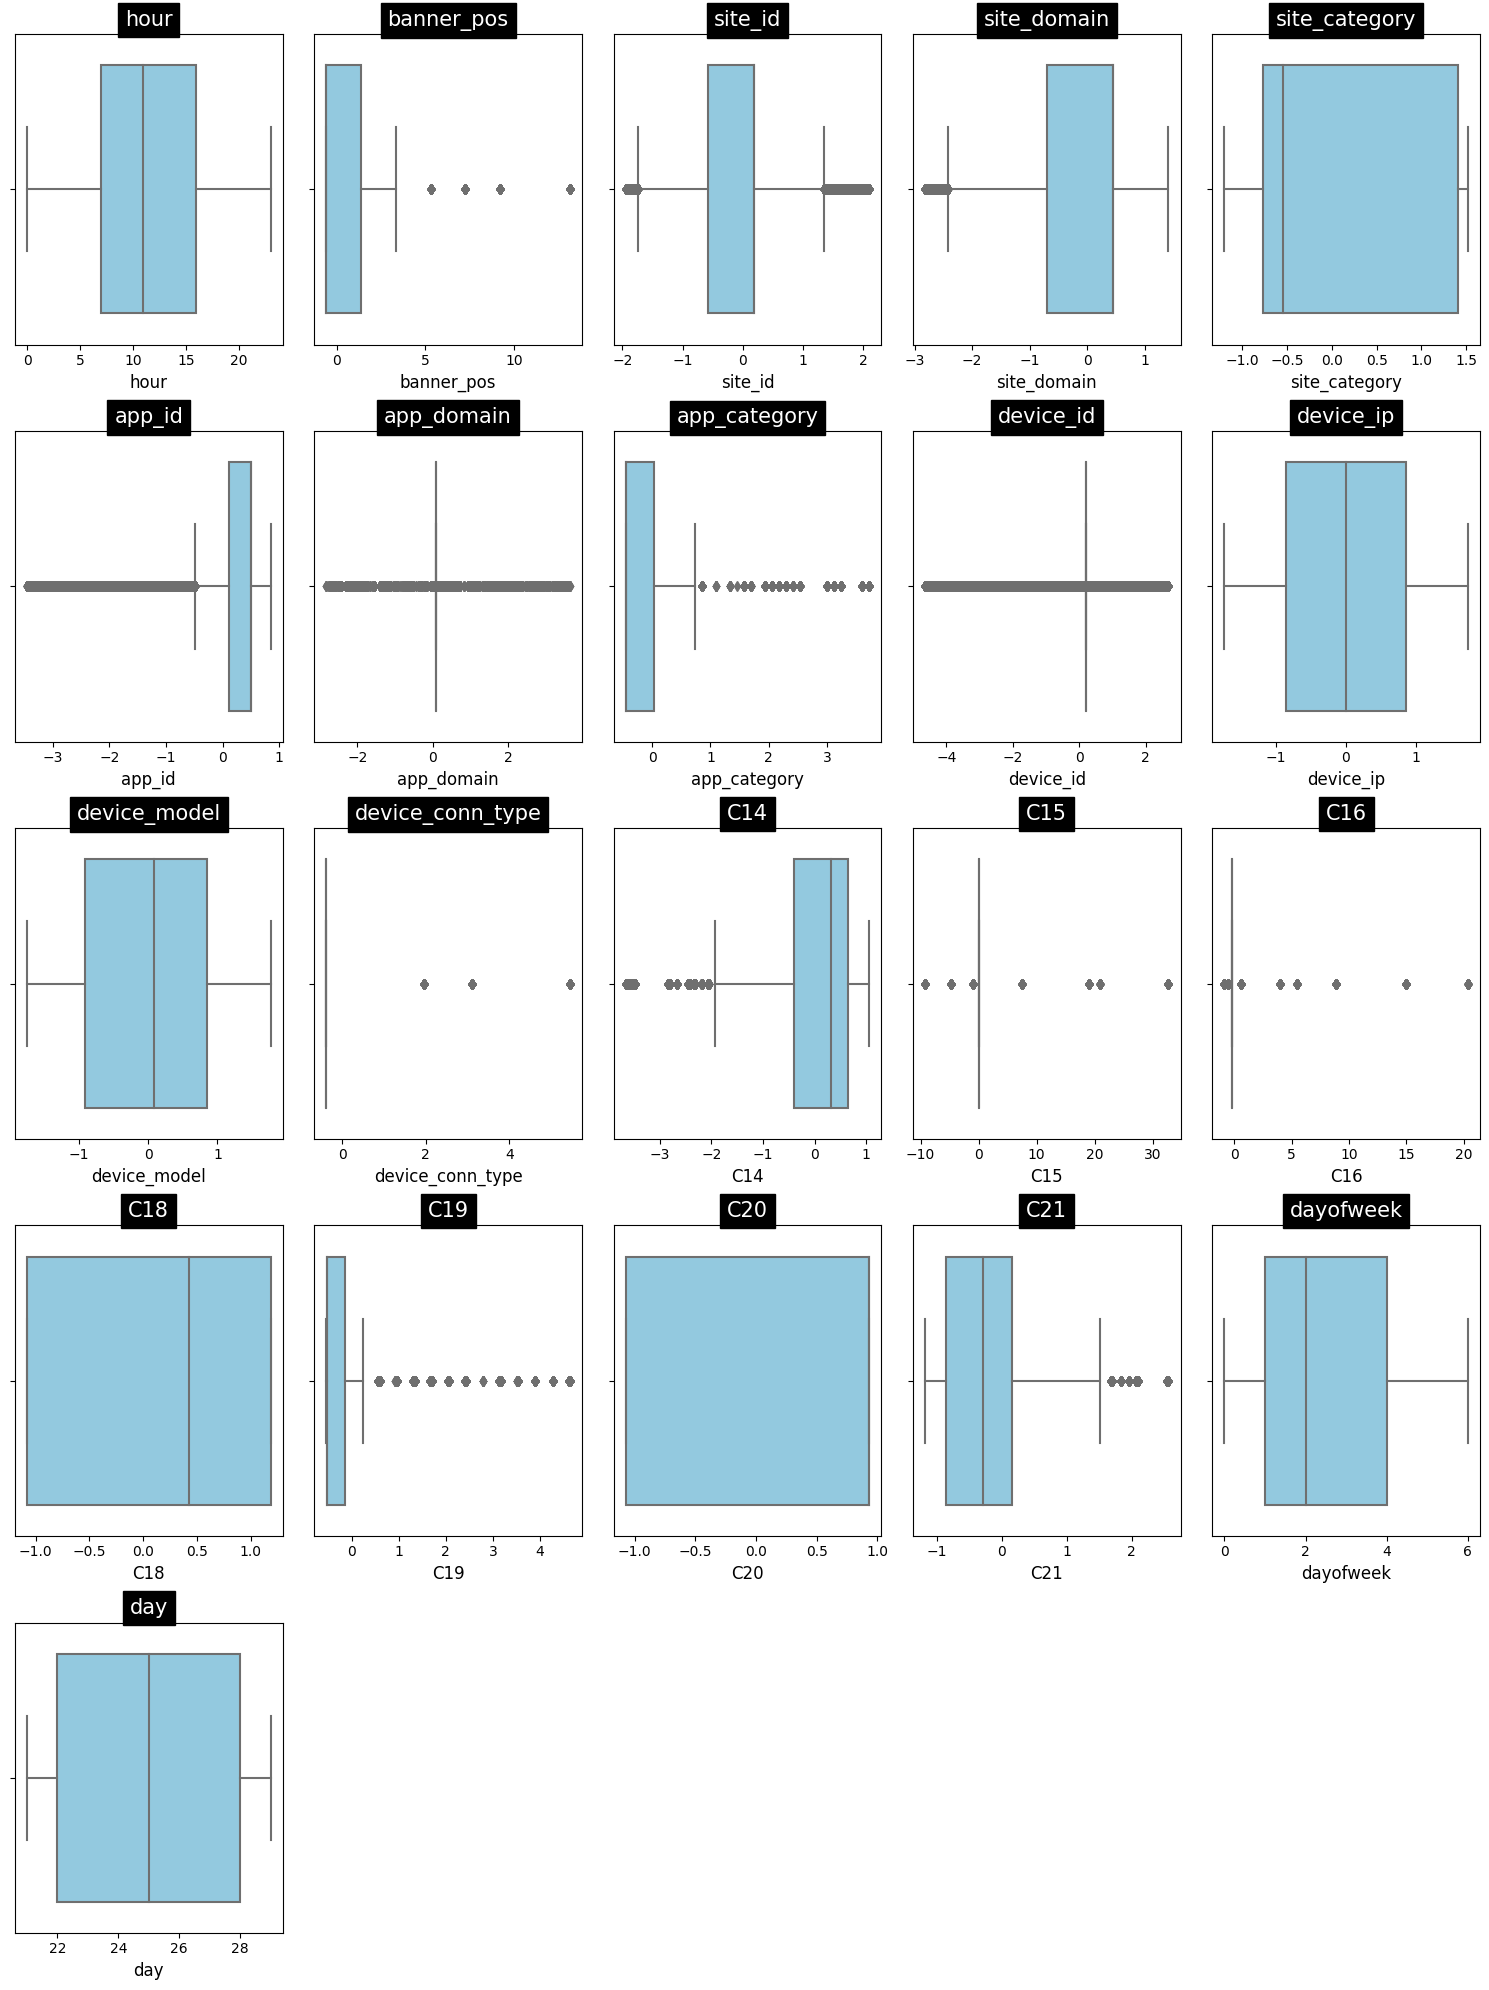

In [ ]:
# We cannot transform categorical X variables
num = X_train.select_dtypes(['number']).columns
num_cols = len(num)
num_rows = (num_cols + 4) // 5
plt.figure(figsize=(15, num_rows * 4))
for idx, i in enumerate(num):
    plt.subplot(num_rows, 5, idx + 1)
    sns.boxplot(x=i, data=X_train, color="#87CEEB") # Use blue sky color
    plt.title(i, backgroundcolor='black', color='white', fontsize=15)
    plt.xlabel(i, size=12)
plt.tight_layout()
plt.show()

## Doing Feature importance

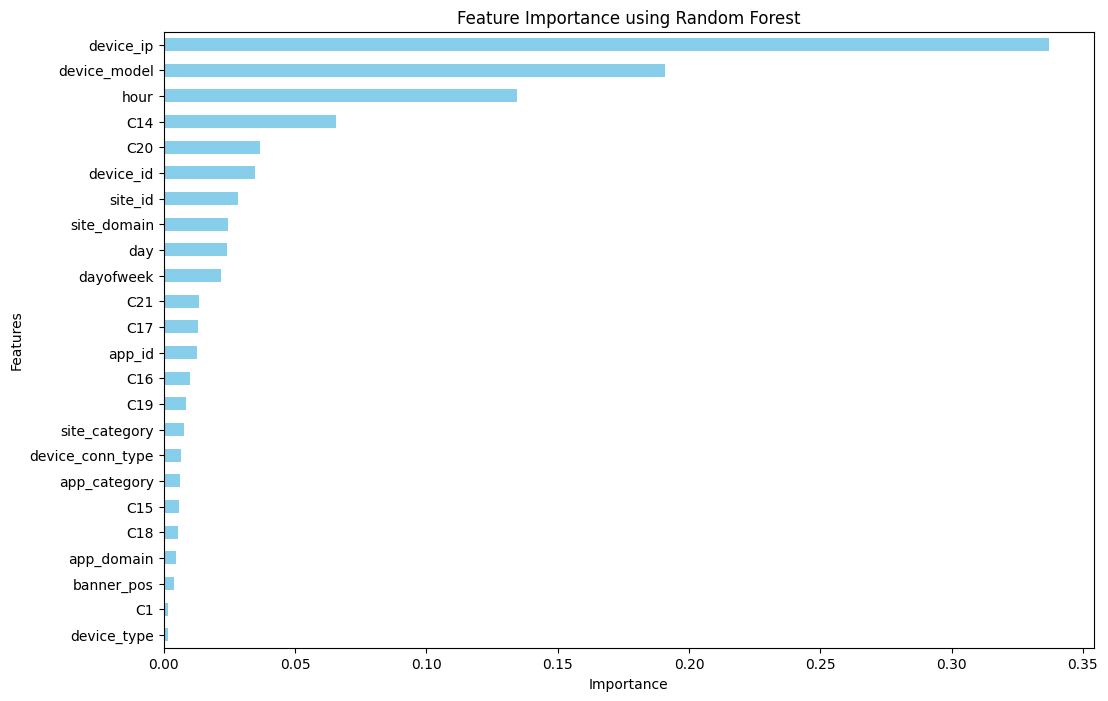

In [ ]:
feature_importance(X_train,y_train)

# Correlation Matrix

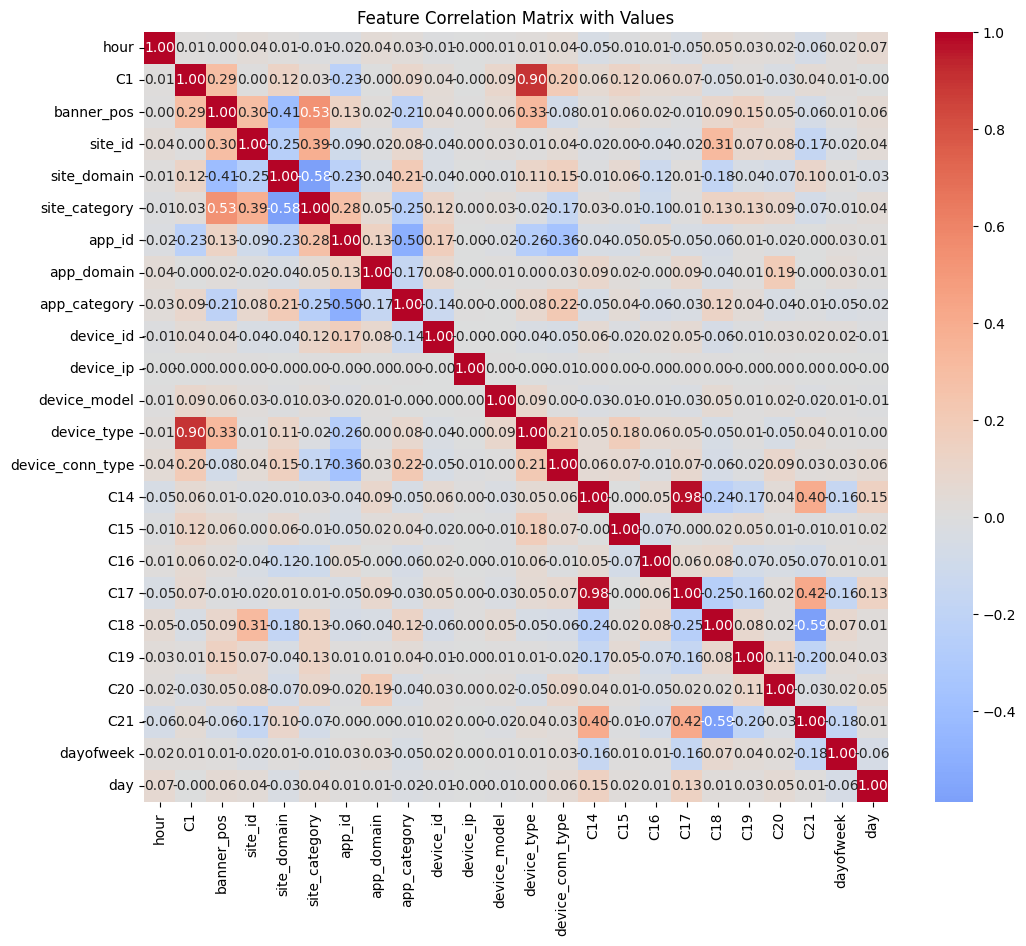

In [ ]:
## Checking the collineallity of features
corr_matrix = pd.DataFrame(X_train).corr()
# Plotting the correlation matrix with annotation for correlation values
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Feature Correlation Matrix with Values')
plt.show()

Based on the correlation matrix provided, the device type and C1 are highly correlated, C14 and C17 as well
From the insights gained from feature importance, device type, C1, C17
We will be removing C1, C17 and device type before modelling.


In [ ]:
## Removing identified features and features related to id
def drop_features (data):
    data = data.drop(['C1', 'C17', 'device_type','site_id'], axis=1)
    return data

In [ ]:
X_train = drop_features(X_train)
X_val = drop_features(X_val)
test = drop_features(test)

In [ ]:
# Concatinating Train and y train data
X_train['click'] = y_train
X_train['click'].value_counts()

0    3320455
1     679545
Name: click, dtype: int64

In [ ]:
X_val['click'] = y_val
X_val['click'].value_counts()

0    830114
1    169886
Name: click, dtype: int64

# Saving data for Training, Validation and Testing

In [ ]:
X_train.to_csv('/content/drive/MyDrive/AI ML Project/Train_data_4M.csv', index=False)
X_val.to_csv('/content/drive/MyDrive/AI ML Project/Val_data_4M', index=False)
test.to_csv('/content/drive/MyDrive/AI ML Project/test_4M', index=False)